 ![logo][gfzlogo]
 
 #   ENHANS -   Exposure modelling Workshop   -  May 2017
 
 ---
 
 
 ## 5.2 - Exposure Modelling
 
 
 ---

 


[gfzlogo]:gfz_logo2.jpg

## language: Python 2.7

### first: Load packages

In [2]:
import sys
import os
import pandas as pd
import numpy as np
from string import Template
import matplotlib.pyplot as plt
%matplotlib inline
#from lxml import etree
from sqlalchemy import create_engine
from sqlalchemy.sql import text

#used by the nrml 
NAMESPACE = 'http://openquake.org/xmlns/nrml/0.5'
GML_NAMESPACE = 'http://www.opengis.net/gml'
SERIALIZE_NS_MAP = {None: NAMESPACE, 'gml': GML_NAMESPACE}


# Query of building data from the database

the data is fetched from the database (either local or from remote) using a SQL query. 

In our case we retrieve the following information:

- latitude (of the centroid of the building)
- longitude (of the centroid of the building)
- ID of the building (same as used in the RRVS interface)
- Building type (estimated)

We suppose that the building type has therefore already been assigned in a previous processing phase 

##Exercise
- Are we querying all available data?

In [3]:
# database connection
engine = create_engine('postgresql://postgres@localhost:5432/rem')

# query to the database
def get_proc_expo(engine,tablename):
    
    sql = """
    select 
    st_x(st_transform(st_centroid(v.the_geom),4326)) lon,
    st_y(st_transform(st_centroid(v.the_geom),4326)) lat,
    v.gid,
    v.btype
    from {} v;""".format(tablename)

    t=pd.read_sql_query(sql,con=engine)
    return t

#test
tt = get_proc_expo(engine,'proc_expo')

## Let us model the building frequencies with a Dirichelet / multinomial distribution

In [21]:
# available building types
btypes = tt['btype'].unique()

#observed frequencies
bdist = tt['btype'].value_counts()/len(tt['btype'])

shape = np.array(bdist).astype(float)

# concentration parameter
con_par=3

# simulation of a Dirichlet process
out = pd.DataFrame(np.random.dirichlet(shape*con_par,10000))

#let´s have a look at some of the simulated distributions
out.head()

,0,1,2
0,0.999139,1.425033e-34,8.610567e-04
1,0.997062,2.539511e-09,2.937578e-03
2,0.605848,1.061161e-05,3.941418e-01
3,0.999272,7.277248e-04,7.403025e-14
4,0.999886,6.259159e-24,1.138712e-04


In [13]:
#let´s define the average occupancy per building type

occ={}
occ['MUR1'] = 10
occ['WOOD1']=7
occ['RC1'] = 20

In [15]:
# let us define the total population in the considered area
pop = 5000

## define a function which is carrying out the disaggregation with a stochastic simulation

In [40]:
def estimate_bdg_num_dirichlet(pop,bdist,con_par = 11):
    shape = np.array(bdist).astype(float)
    
    #simulate dirichlet distrib. on the cell
    out = pd.DataFrame(np.random.dirichlet(shape*con_par,10000))
    
    out.columns = btypes
    occs = [occ[tax] for tax in btypes]

    nb=[]
    for ind, row in out.iterrows():
        nb.append(pop/sum(np.array(occs)*np.array(row)))
        #nb.append(pop/sum(np.array(row.iloc[0])*occs))
        
    return pd.DataFrame([[int(np.average(nb)),int(np.std(nb)),int(np.min(nb)),int(np.max(nb)),
int(np.percentile(nb,5)),int(np.percentile(nb,50)),int(np.percentile(nb,95))]],columns=['avg','stddev','min','max','q5','q50','q95'])


#test
#estimate_bdg_num_dirichlet(pop,bdist,3)

## now we can compute the expected number of buildings in a probabilistic framework

In [38]:
res = estimate_bdg_num_dirichlet(pop,bdist,3)
print res


   avg  stddev  min  max   q5  q50  q95
0  496      23  277  672  462  500  509


(array([   28.,   221.,   821.,  2042.,  2883.,  2480.,  1174.,   297.,
           49.,     5.]),
 array([ 414.98991773,  432.35576044,  449.72160316,  467.08744587,
         484.45328858,  501.8191313 ,  519.18497401,  536.55081672,
         553.91665944,  571.28250215,  588.64834487]),
 <a list of 10 Patch objects>)

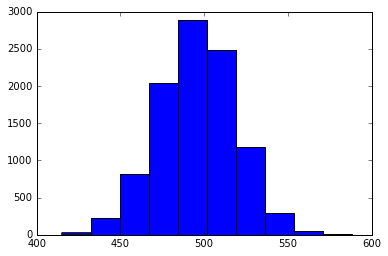

In [39]:
plt.hist(np.random.normal(res['avg'],res['stddev'],10000))

---

---

# Using boundary data

Boundary data provide a geographical support for aggregating the exposure model.

Boundary data can be:
- geographical (e.g. a continent, an isle)
- administrative (e.g. political borders, regions, districts, postal codes)
- abstract (geocell, regular grids)

Moreover, boundary data can nest into each other, therefore providing a natural multi-resolution support.

###How do we manage multiple boundary data in exposure modelling ?

In [41]:
# database connection
engine = create_engine('postgresql://postgres@localhost:5432/exposure_wb')

# query to the database, also include a list of table names specifying different boundary data layers.
# each boundary layer must include a geometry the_geom, a name name_en and an id object_id. 
def get_exp_bd(engine, tablename,boundaries):
    
    boundaries_pa=''
    boundaries_pb=''
    boundaries_pc=''
    
    for i,b in enumerate(boundaries):
        boundaries_pa += 'b{}.name_en name_b{},b{}.object_id id_b{},'.format(i,i,i,i)
        boundaries_pb += '{} b{},'.format(b,i)
        boundaries_pc += ' st_contains(b{}.the_geom,st_centroid(v.the_geom)) and'.format(i)
    
    sql = """
    select 
    st_x(st_transform(st_centroid(v.the_geom),4326)) lon,
    st_y(st_transform(st_centroid(v.the_geom),4326)) lat,
    v.the_geom,
    v.gid,
    v.e_bdgtype btype,
    {}
    from {} v, {} 
    where {}; """.format(boundaries_pa[:-1],tablename,boundaries_pb[:-1],boundaries_pc[:-3])
    
    #print sql
    
    t=pd.read_sql_query(sql,con=engine)
    return t

#test
tt = get_exp_bd(engine,'bdgs_est2',['boundary0','boundary1','boundary2'])

##Let us check how many different entries are present in each aggregation boundary. 

In [46]:
tt.groupby(['name_b0','name_b1','name_b2'])['btype'].value_counts()

name_b0     name_b1       name_b2          btype
kyrgyzstan  Batken        Batken-city      c4        52
                                           c1.3       6
                                           c2.4       2
                                           c1.1       1
                          Batkensky        c4       204
                                           c1.3      28
                                           c1.1       3
                                           c6         1
                          Kadamjaisky      c4       125
                                           c1.3      17
                                           c1.1       1
                                           c2.1       1
                          Kyzyl-Kiya-city  c4        62
                                           c1.3      37
                                           c3.1       2
                                           c1.1       1
                          Lyailyaksky      c4       229

## ... and write back the processed data into the database

In [168]:
#sql query to join the processed table with the information in the rrvs database
sqltempquery = Template('drop table if exists $tablename;\
create table $tablename as \
select v.*, p.btype \
from asset.ve_object v inner join $tablename_tmp p \
on v.object_id = p.object_id;\
drop table if exists $tablename_tmp;')

# function to export the processed building information to the database
def export_database(df, tablename):
    sql_pars=dict(tablename ='{}'.format(tablename),
                  tablename_tmp = '{}_tmp'.format(tablename))
    engine.execute(text("drop table if exists {};".format(sql_pars['tablename_tmp'])))
    df.to_sql(sql_pars['tablename_tmp'],engine)
    t = sqltempquery.substitute(sql_pars)
    engine.execute(text(t))

# create the processed table in the public schema of the database
export_database(expo_df,'proc_expo')

##Exercise
The resulting model can now be queried from the database and mapped using QGIS. Try this out!

